## Lab 2: Classification
Group 2 Team Members:

- Name 1: Aniketh Vankina
- Name 2: Indy Dhillon 
- Name 3: Jason Rupp 
- Name 4: Suchismita Moharana 

# Intro

The dataset selected for this project was collected by the US Census Bureau and the Bureau of Labor Statistics over the course of 1994 and 1995 for the Current Population Survey (CPS). The main purpose of the CPS is to obtain current information on the status of the labor force in the United States. More specifically, this survey is conducted to enumerate the number of jobless and unemployed individuals as well as to get an idea about the social well-being of the citizens. This data was obtained from the University of California Irvine Machine Learning repository, which a citation and a direct link to the dataset can be found [here](https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html). 

The purpose of this project is to perform classification tasks with differing machine learning models on two features of this data set and explain the findings.

In [1]:
#Loading Libraries
import warnings
warnings.filterwarnings('ignore')

import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

np.random.seed(1)

In [2]:
# Header names

header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]

In [3]:
# Load data
data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df.drop(columns=['instance_weight']) ## not used for our analysis

,age,class_worker,det_ind_code,det_occ_code,education,wage_per_hour,hs_college,marital_stat,major_ind_code,major_occ_code,...,country_father,country_mother,country_self,citizenship,own_or_self,vet_question,vet_benefits,weeks_worked,year,income_50k
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
99758,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
99759,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
99760,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.


## Data Preparation Part 1

The first classification task performed will be on an income based feature called `income_50k`. The feature indicates whether the person earns more than $50,000 annually, represented with "+50000" or below, represented as "-50,000". The second classification task will be on a variable which will be generated from the dataset. This variable pertains the the level of education a person has attained. The feature has been created such that, if a person has earned a 4-year/bachelor degree or higher they will have considered to have graduated. The name of this feature is `graduated` and it is a boolean value, with yes indicating if a person has earned a higher education degree, or not. It was created from the categorical feature from the dataset called `education`. Further in the report, this variable will be created, and the education feature will be dropped. 

In [4]:
# Categorical features in the data, variable will be used for one-hot encoding
categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

This dataset is mostly comprised of categorical features. The above variable will be used to hold the name of these features, and will later be used to one-hot encode all that are represented, with exception to those that are to be dropped before analysis.

In [5]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)

The above features were not included in the dataset. Many of these features were dropped because it was decided that there were too many values each could assume. For instance, as shown above, the `state_prev_res` variable could be 1 of the 50 states. Additionally, if this didn't pertain to the person represented in this row, it would be an NA value, and many rows took this form. 

In [6]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

The function above will act as the preprocessing pipeline. The numeric features will be scaled using the standard scaling, and the categorical features will be one-hot encoded. This function will return a pipeline object with scaled numeric features, and one-hot encoded categorical features in a sparse matrix.

In [7]:
# This is section one of the data processing, will be using the same data as shown in the minilab
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299285 entries, 0 to 99761
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   age               299285 non-null  int64   
 1   class_worker      299285 non-null  category
 2   det_ind_code      299285 non-null  category
 3   det_occ_code      299285 non-null  category
 4   education         299285 non-null  category
 5   wage_per_hour     299285 non-null  int64   
 6   hs_college        299285 non-null  category
 7   marital_stat      299285 non-null  category
 8   major_ind_code    299285 non-null  category
 9   major_occ_code    299285 non-null  category
 10  race              299285 non-null  category
 11  hisp_origin       299285 non-null  category
 12  sex               299285 non-null  category
 13  union_member      299285 non-null  category
 14  unemp_reason      299285 non-null  category
 15  full_or_part_emp  299285 non-null  category
 16  cap

Above are the attributes that will be used in initial stages of modeling. These features will be processed with the pipeline, then will be further selected with recursive feature engineering later in the report.

In [8]:
# Sampling the dataset
selection_df = df.sample(frac = .001)

In [9]:
selection_df.shape

(299, 29)

In [10]:
numeric_features = selection_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features_income = selection_df.select_dtypes(include=['object','bool', 'category']).drop(['income_50k'], axis=1).columns
X_selection_income = selection_df.drop('income_50k', axis=1)
y_selection_income = pd.DataFrame(selection_df['income_50k'])
preprocessor_income = preprocess_pipeline(numeric_features, categorical_features_income)
X_selection_preprocessed_income = preprocessor_income.fit_transform(X_selection_income)

The above code chunk will process the data for the first classification task on the income attribute.

In [11]:
higer_degrees = [
    ' Bachelors degree(BA AB BS)', 
    ' Masters degree(MA MS MEng MEd MSW MBA)', 
    ' Prof school degree (MD DDS DVM LLB JD)',
    ' Doctorate degree(PhD EdD)',
]
selection_df['graduated'] = 'no'
selection_df.loc[selection_df['education'].isin(higer_degrees), 'graduated'] = 'yes'
selection_df = selection_df.drop(['education'], axis=1)

In [12]:
selection_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 67087 to 96041
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               299 non-null    int64   
 1   class_worker      299 non-null    category
 2   det_ind_code      299 non-null    category
 3   det_occ_code      299 non-null    category
 4   wage_per_hour     299 non-null    int64   
 5   hs_college        299 non-null    category
 6   marital_stat      299 non-null    category
 7   major_ind_code    299 non-null    category
 8   major_occ_code    299 non-null    category
 9   race              299 non-null    category
 10  hisp_origin       299 non-null    category
 11  sex               299 non-null    category
 12  union_member      299 non-null    category
 13  unemp_reason      299 non-null    category
 14  full_or_part_emp  299 non-null    category
 15  capital_gains     299 non-null    int64   
 16  capital_losses    29

This chunk prepares the new feature used in for the second classification problem. The education and hs_college features were subsequently be dropped, as leaving these features in the dataset will create falsely high classification accuracies during modeling.

In [13]:
categorical_features_grad = selection_df.select_dtypes(include=['object','bool', 'category']).drop(['graduated'], axis=1).columns
X_selection_grad = selection_df.drop(columns=['graduated'])
y_selection_grad = pd.DataFrame(selection_df['graduated'])
preprocessor_grad = preprocess_pipeline(numeric_features, categorical_features_grad)
X_selection_preprocessed_grad = preprocessor_grad.fit_transform(X_selection_grad)

As above, this chunk will process the dataset for the second classification task of `graduated`. 

In [14]:
tmp_df = pd.get_dummies(y_selection_income['income_50k'])

y_selection_income = pd.concat((y_selection_income,tmp_df),axis=1)

y_selection_income["above_50k"] = y_selection_income[" 50000+."]

y_selection_income=y_selection_income.drop(['income_50k', " - 50000.", " 50000+."], axis=1)

In [15]:
tmp_df = pd.get_dummies(y_selection_grad['graduated'])

y_selection_grad = pd.concat((y_selection_grad,tmp_df),axis=1)

y_selection_grad["graduated"] = y_selection_grad["yes"]

y_selection_grad=y_selection_grad.drop(['yes', "no"], axis=1)

In [16]:
### Make a list of all the columns after one hot encoding
ohe_income = preprocessor_income['preprocessor'].named_transformers_['cat']['onehot']
cat_processed_income = ohe_income.get_feature_names(X_selection_income[categorical_features_income].columns)
all_processed_cols_income = np.concatenate((numeric_features, cat_processed_income), axis=0)

In [17]:
ohe_grad = preprocessor_grad['preprocessor'].named_transformers_['cat']['onehot']
cat_processed_grad = ohe_grad.get_feature_names(X_selection_grad[categorical_features_grad].columns)
all_processed_cols_grad = np.concatenate((numeric_features, cat_processed_grad), axis=0)

Optimal number of features for Income: 13
Max Score : 0.27


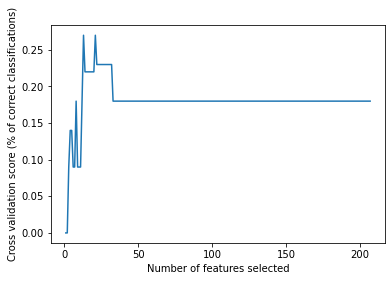

In [18]:
from sklearn.metrics import recall_score

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv_income = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_income.fit(X_selection_preprocessed_income, y_selection_income)
print("Optimal number of features for Income: %d" % rfecv_income.n_features_)
print("Max Score :", max(rfecv_income.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_income.grid_scores_) + 1), rfecv_income.grid_scores_)
plt.show()

Recursive feature engineering was done with a logistic regression classifier to identify the which features will be useful for the modeling process and to identify which number will be needed to attain this highest accuracy with logistic regression. Above are the results for the first classification task.

Optimal number of features for Graduated: 20
Max Score : 0.4984848484848484


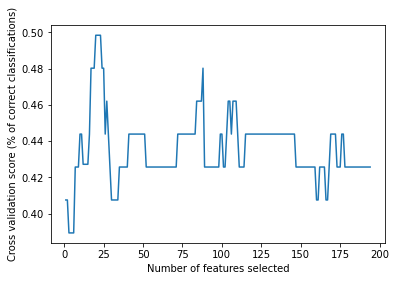

In [19]:
import warnings
warnings.filterwarnings('ignore')

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv_grad = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_grad.fit(X_selection_preprocessed_grad, y_selection_grad)
print("Optimal number of features for Graduated: %d" % rfecv_grad.n_features_)
print("Max Score :", max(rfecv_grad.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_grad.grid_scores_) + 1), rfecv_grad.grid_scores_)
plt.show()

This is the feature selection task for the second classification problem for this report.

In [20]:
### Show all selected features
selected_features_income = all_processed_cols_income[rfecv_income.support_]
print(selected_features_income)

['weeks_worked' 'det_ind_code_12' 'det_ind_code_19' 'det_occ_code_2'
 'det_occ_code_17' 'education_ Masters degree(MA MS MEng MEd MSW MBA)'
 'marital_stat_ Divorced' 'major_ind_code_ Manufacturing-durable goods'
 'major_ind_code_ Public administration' 'major_occ_code_ Sales'
 'hisp_origin_ All other' 'sex_ Male' 'unemp_reason_ Not in universe']


In [21]:
selected_features_grad = all_processed_cols_grad[rfecv_grad.support_]
print(selected_features_grad)

['class_worker_ Federal government' 'det_ind_code_12' 'det_ind_code_48'
 'det_ind_code_50' 'det_occ_code_10' 'det_occ_code_17' 'det_occ_code_18'
 'det_occ_code_38' 'major_ind_code_ Hospital services'
 'major_ind_code_ Retail trade' 'major_occ_code_ Other service'
 'major_occ_code_ Precision production craft & repair'
 'major_occ_code_ Professional specialty'
 'major_occ_code_ Technicians and related support'
 'hisp_origin_ All other' 'unemp_reason_ Job leaver'
 'fam_under_18_ Not in universe' 'own_or_self_1' 'vet_benefits_0'
 'income_50k_ - 50000.']


In [22]:
### log 
X_selection_log_income = X_selection_income.copy()
X_selection_log_income['wage_per_hour'] = np.log10(X_selection_log_income['wage_per_hour'] + 1)
X_selection_log_income['capital_gains'] = np.log10(X_selection_log_income['capital_gains'] + 1)
X_selection_log_income['capital_losses'] = np.log10(X_selection_log_income['capital_losses'] + 1)
X_selection_log_income['stock_dividends'] = np.log10(X_selection_log_income['stock_dividends'] + 1)
X_selection_log_preprocessed_income = preprocessor_income.fit_transform(X_selection_log_income)

X_selection_log_grad = X_selection_grad.copy()
X_selection_log_grad['wage_per_hour'] = np.log10(X_selection_log_grad['wage_per_hour'] + 1)
X_selection_log_grad['capital_gains'] = np.log10(X_selection_log_grad['capital_gains'] + 1)
X_selection_log_grad['capital_losses'] = np.log10(X_selection_log_grad['capital_losses'] + 1)
X_selection_log_grad['stock_dividends'] = np.log10(X_selection_log_grad['stock_dividends'] + 1)
X_selection_log_preprocessed_grad = preprocessor_grad.fit_transform(X_selection_log_grad)


Above the numeric features of the dataset are log transformed in an attempt to improve the accuracy of the RFE and to compare with the results already obtained.

Optimal number of features for Income: 38
Max Score : 0.36


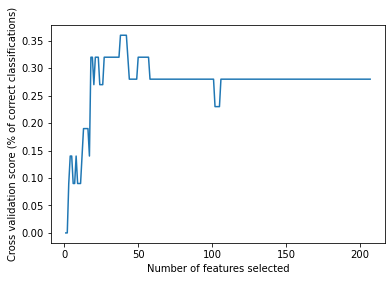

In [23]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log_income = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_log_income.fit(X_selection_log_preprocessed_income, y_selection_income)
print("Optimal number of features for Income: %d" % rfecv_log_income.n_features_)
print("Max Score :", max(rfecv_log_income.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log_income.grid_scores_) + 1), rfecv_log_income.grid_scores_)
plt.show()

Optimal number of features for Graduated: 20
Max Score : 0.4984848484848484


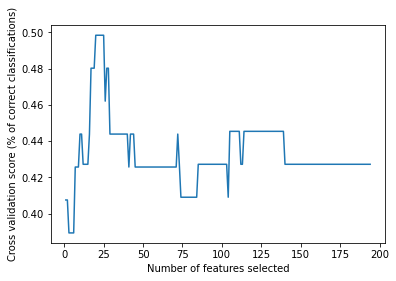

In [24]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log_grad = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_log_grad.fit(X_selection_log_preprocessed_grad, y_selection_grad)
print("Optimal number of features for Graduated: %d" % rfecv_log_grad.n_features_)
print("Max Score :", max(rfecv_log_grad.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log_grad.grid_scores_) + 1), rfecv_log_grad.grid_scores_)
plt.show()

Another round of RFE was performed on the dataset after log transformation of the numeric variables to see if the recall would improve. There was not a significant increase in recall this will not be done on the final dataset used for modeling.

## Data Preparation Part 2

In [25]:
### Show all selected features
#index columns of sparse matrix
X_selected_income = X_selection_preprocessed_income.tocsr()[:,rfecv_income.support_] 
selected_features_income = all_processed_cols_income[rfecv_income.support_]

print(selected_features_income)

['weeks_worked' 'det_ind_code_12' 'det_ind_code_19' 'det_occ_code_2'
 'det_occ_code_17' 'education_ Masters degree(MA MS MEng MEd MSW MBA)'
 'marital_stat_ Divorced' 'major_ind_code_ Manufacturing-durable goods'
 'major_ind_code_ Public administration' 'major_occ_code_ Sales'
 'hisp_origin_ All other' 'sex_ Male' 'unemp_reason_ Not in universe']


In [26]:
X_selected_grad = X_selection_preprocessed_grad.tocsr()[:,rfecv_grad.support_] 
selected_features_grad = all_processed_cols_grad[rfecv_grad.support_]

print(selected_features_grad)

['class_worker_ Federal government' 'det_ind_code_12' 'det_ind_code_48'
 'det_ind_code_50' 'det_occ_code_10' 'det_occ_code_17' 'det_occ_code_18'
 'det_occ_code_38' 'major_ind_code_ Hospital services'
 'major_ind_code_ Retail trade' 'major_occ_code_ Other service'
 'major_occ_code_ Precision production craft & repair'
 'major_occ_code_ Professional specialty'
 'major_occ_code_ Technicians and related support'
 'hisp_origin_ All other' 'unemp_reason_ Job leaver'
 'fam_under_18_ Not in universe' 'own_or_self_1' 'vet_benefits_0'
 'income_50k_ - 50000.']


Above are the lists of features that were selected from RFE for each classification task. The first list shows that features that will be used for the income classification task, and the second list shows that features for the graduated classification task.

The final processed dataset is a sparse array representing the variables as numeric after scaling the numeric features and one-hot encoding the categorical attributes.

In [27]:
type(X_selected_income)

scipy.sparse.csr.csr_matrix

As stated before, a feature was created for second classification task being the graduation status. If a person has attained a higher education degree, they will be considered to have graduated. Below is the description of the dataset that will be used for the newly created `graduated` feature.

In [28]:
type(X_selected_grad)


scipy.sparse.csr.csr_matrix

## Modeling and Evaluation

In [29]:
#### Decision Tree for income
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    
}

CV_dt_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_dt_income.fit(X_selected_income, y_selection_income)
    
print('Best Score: {s}'.format(s=CV_dt_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_dt_income.best_params_))  

Best Score: 0.3333333333333333
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}


In [30]:
#### Decision Tree for graduation
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    
}

CV_dt_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_dt_grad.fit(X_selected_grad, y_selection_grad)
    
print('Best Score: {s}'.format(s=CV_dt_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_dt_grad.best_params_))  

Best Score: 0.56
Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [31]:
#Feature importance graph
#imp = dt_clf.feature_importances_

#Plt
#plt.bar(range(len(imp)),imp)

In [32]:
#### Logistic Regression for income
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_lr_income.fit(X_selected_income, y_selection_income)
    
print('Best Score: {s}'.format(s=CV_lr_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr_income.best_params_)) 


Best Score: 0.7833333333333333
Best Parameters: {'class_weight': 'balanced', 'max_iter': 99999, 'solver': 'lbfgs'}


In [33]:
#### Logistic Regression for graduation
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_lr_grad.fit(X_selected_grad, y_selection_grad)
    
print('Best Score: {s}'.format(s=CV_lr_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr_grad.best_params_)) 

Best Score: 0.7133333333333334
Best Parameters: {'class_weight': 'balanced', 'max_iter': 99999, 'solver': 'lbfgs'}


In [34]:
#### KNN for income
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,200],
    'weights': ['uniform', 'distance']
}
CV_knn_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_knn_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_knn_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn_income.best_params_))


Best Score: 0.2833333333333333
Best Parameters: {'n_neighbors': 5, 'weights': 'uniform'}


In [35]:
#### KNN for graduation
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,200],
    'weights': ['uniform', 'distance']
}
CV_knn_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_knn_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_knn_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn_grad.best_params_))

Best Score: 0.5033333333333333
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}


In [36]:
#### AdaBoost for income
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_ada_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_ada_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada_income.best_params_))

Best Score: 0.4833333333333333
Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 100}


In [37]:
#### AdaBoost for graduation
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_ada_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_ada_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada_grad.best_params_))


Best Score: 0.5733333333333335
Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 200}


In [38]:
#### Gradient Boosting for income
from sklearn.ensemble import GradientBoostingClassifier

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

classifier = GradientBoostingClassifier(random_state=1)


CV_gbc_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_gbc_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_gbc_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc_income.best_params_))

Best Score: 0.4333333333333334
Best Parameters: {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 100}


In [39]:
#### Gradient Boosting for graduation
from sklearn.ensemble import GradientBoostingClassifier

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

classifier = GradientBoostingClassifier(random_state=1)


CV_gbc_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_gbc_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_gbc_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc_grad.best_params_))

Best Score: 0.6300000000000001
Best Parameters: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 10}


### Model and Evaluation 1

In our analysis we decided to use the accuracy as the appropriate measure for interpreting the power of our models. Since our project mainly deals with classification, we found that the accuracy is the best measure for how well our models are doing. When we are talking about accuracy, we mainly are talking about the number of correct predictions made over the total predictions made by the model. In our scenario, we are trying to predict whether the income is over or under 50k and graduation (whether the individual graduated from high school or college). Accuracy is a good metric to look at when we have balanced datasets. 

### Model and Evaluation 2

For the models we have created, we have been using stratified 10-fold cross validation. This method is being applied when we are running the GridSearchCV function which also gives us the best parameters to use for that chosen model. We went with the stratified method since this a binary classification problem and we want balanced classes. Especially, since we are working with a large number of values, the balance is important which stratified helped us achieve. This is so that the data is arranged in a way that every fold comprises of half the instances. This will also prove useful because we want to see which one our three models will do well using this type of cross validation. 

### Model and Evaluation 3

### Model and Evaluation 4

In [40]:
import yellowbrick 
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix


from yellowbrick.classifier import ROCAUC
#%matplotlib inline


def plot_rocauc_chart(model_name, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10,4))
    plt.title("ROC Curve and AUC", fontsize=18)
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    visualizer = ROCAUC(model_name, classes=["Not-churned", "Churned"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    plt.legend()
    plt.show()
    
    
def plot_confusionmatrix(model_name, X_train, y_train, X_test, y_test):
#    confusion_matrix(model_name, X_train, y_train, X_test, y_test,classes=[0,1])
#    plt.tight_layout()    
    plt.figure()
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Class", fontsize=16)
    plt.ylabel("True Class", fontsize=15)
    cm = ConfusionMatrix(model_name, classes=[0,1], size=(250,250), fontsize=15, cmap='GnBu')
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    plt.show()


In [41]:
X_grad_train, X_grad_test, y_grad_train, y_grad_test = train_test_split(X_selected_grad, y_selection_grad, test_size=0.2)


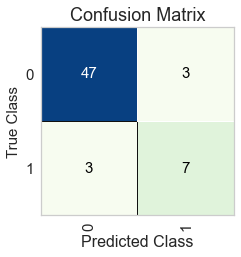

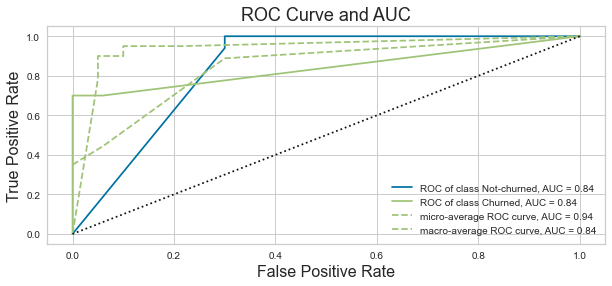

In [42]:
#Decision Tree: confusion matrix and ROC curve and AUC for Graduate classification
plot_confusionmatrix(CV_dt_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)
plot_rocauc_chart(CV_dt_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)


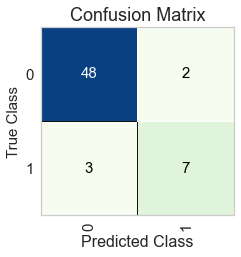

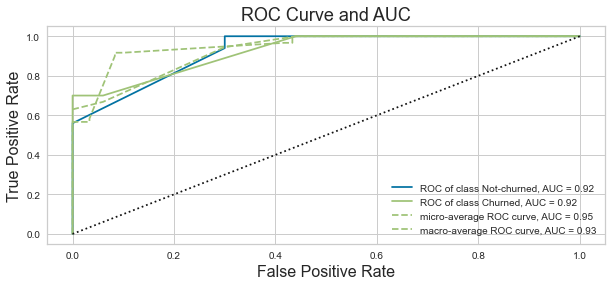

In [43]:
#Logistics Regression: confusion matrix and ROC curve and AUC for Graduate classification
plot_confusionmatrix(CV_lr_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)
plot_rocauc_chart(CV_lr_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

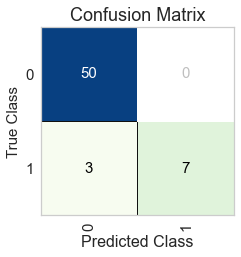

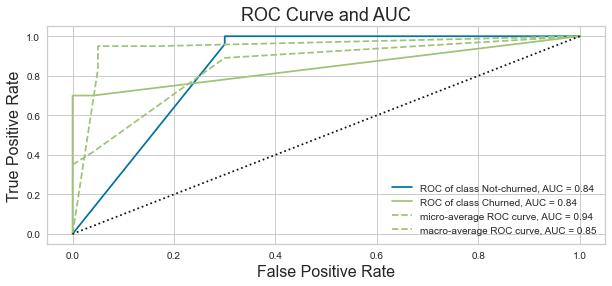

In [44]:
#KNN: confusion matrix and ROC curve and AUC for Graduate classification
plot_confusionmatrix(CV_knn_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)
plot_rocauc_chart(CV_knn_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

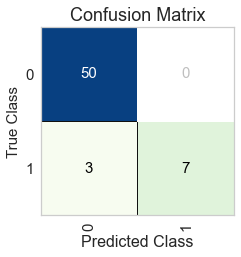

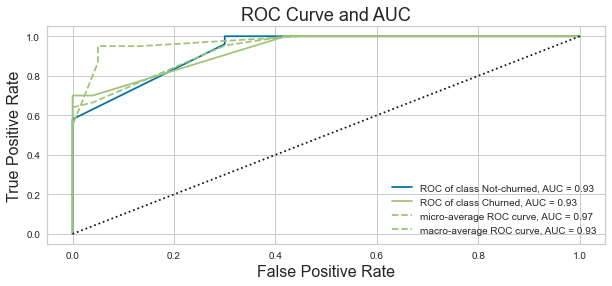

In [45]:
#Ada boost: confusion matrix and ROC curve and AUC for Graduate classification
plot_confusionmatrix(CV_ada_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)
plot_rocauc_chart(CV_ada_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

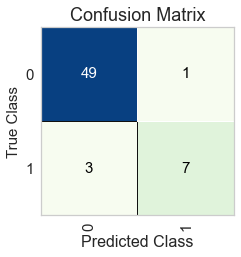

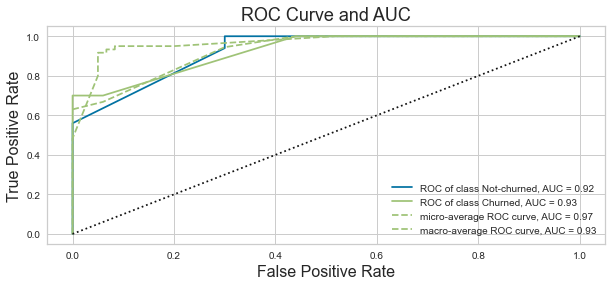

In [46]:
#Gradient boost: confusion matrix and ROC curve and AUC for Graduate classification
plot_confusionmatrix(CV_gbc_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)
plot_rocauc_chart(CV_gbc_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

In [47]:
X_income_train, X_income_test, y_income_train, y_income_test = train_test_split(X_selected_income, y_selection_income, test_size=0.2)

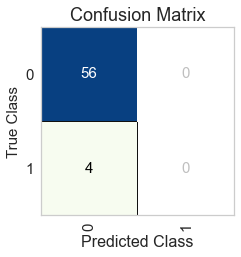

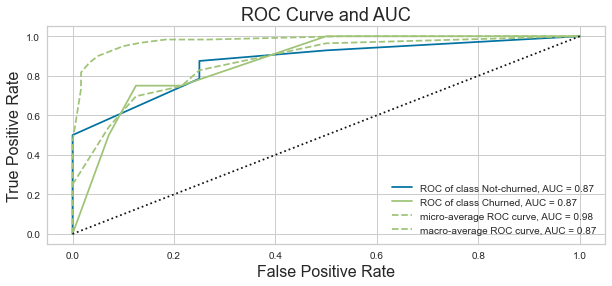

In [48]:
#Decision Tree: confusion matrix and ROC curve and AUC for Income classification
plot_confusionmatrix(CV_dt_income, X_income_train, y_income_train, X_income_test, y_income_test)
plot_rocauc_chart(CV_dt_income, X_income_train, y_income_train, X_income_test, y_income_test)

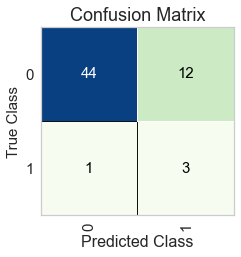

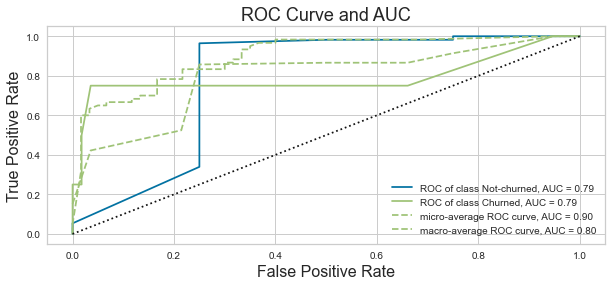

In [49]:
#Logistics Regression: confusion matrix and ROC curve and AUC for Income classification
plot_confusionmatrix(CV_lr_income, X_income_train, y_income_train, X_income_test, y_income_test)
plot_rocauc_chart(CV_lr_income, X_income_train, y_income_train, X_income_test, y_income_test)

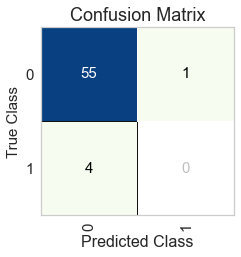

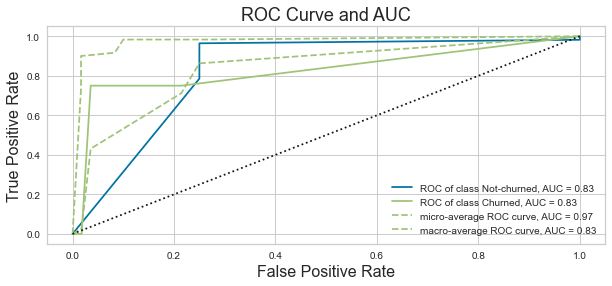

In [50]:
#KNN : confusion matrix and ROC curve and AUC for Income classification
plot_confusionmatrix(CV_knn_income, X_income_train, y_income_train, X_income_test, y_income_test)
plot_rocauc_chart(CV_knn_income, X_income_train, y_income_train, X_income_test, y_income_test)

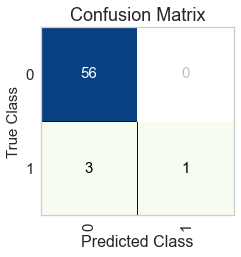

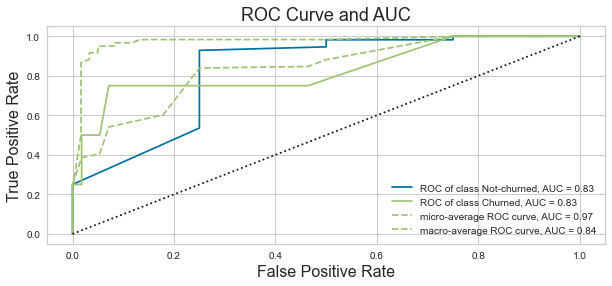

In [51]:
#Ada boost: confusion matrix and ROC curve and AUC for Income classification
plot_confusionmatrix(CV_ada_income, X_income_train, y_income_train, X_income_test, y_income_test)
plot_rocauc_chart(CV_ada_income, X_income_train, y_income_train, X_income_test, y_income_test)

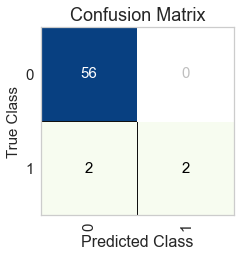

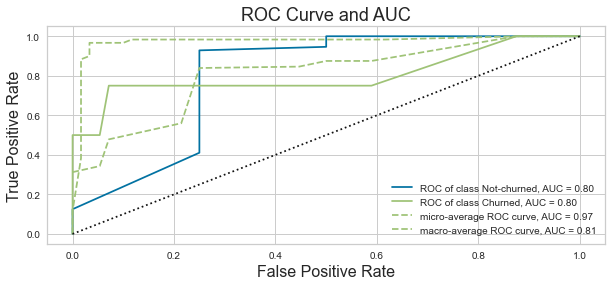

In [52]:
#Gradient boost: confusion matrix and ROC curve and AUC for Income classification
plot_confusionmatrix(CV_gbc_income, X_income_train, y_income_train, X_income_test, y_income_test)
plot_rocauc_chart(CV_gbc_income, X_income_train, y_income_train, X_income_test, y_income_test)

### Model and Evaluation 5

### Model and Evaluation 6

### Deployment

### Exceptional Work